# Language Technology - 6th Tutorial on Transformers with Keras


----
## Important Resources

Language Technology Resources: https://eclass.aueb.gr/modules/document/index.php?course=INF210

Python Official Documentation: https://docs.python.org/3.5/

Keras: https://keras.io/

Keras examples: https://github.com/fchollet/keras/tree/master/examples

----

## Implementation of Transformers (Vaswani et al., 2017) in Keras



<img src="https://camo.githubusercontent.com/4b80977ac0757d1d18eb7be4d0238e92673bfaba/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f7472616e73666f726d65722e706e67" />



## Layer Normalization

**Python Example Code**

In [39]:
from keras import backend as K
from keras.layers.core import Layer
from keras.initializers import Ones, Zeros


class LayerNormalization(Layer):
    def __init__(self, eps: float = 1e-5, **kwargs) -> None:
        self.eps = eps
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:], initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:], initializer=Zeros(), trainable=True)
        super().build(input_shape)

    def call(self, x, **kwargs):
        u = K.mean(x, axis=-1, keepdims=True)
        s = K.mean(K.square(x - u), axis=-1, keepdims=True)
        z = (x - u) / K.sqrt(s + self.eps)
        return self.gamma * z + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'eps': self.eps,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Positional Encodings

**Python Example Code**

In [40]:
from keras.layers import Embedding
import numpy as np

def _get_pos_encoding_matrix(max_len: int, d_emb: int) -> np.array:
    pos_enc = np.array(
        [[pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] if pos != 0 else np.zeros(d_emb) for pos in
         range(max_len)], dtype=np.float32)
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

PositionalEncoding = Embedding(100, 200, trainable=False, input_length=100, 
                               weights=[_get_pos_encoding_matrix(100, 200)], name='PositionEmbedding')

## Multi-head Attention

**Python Example Code**

In [41]:
from keras import backend as K
from keras.layers.core import Layer

class MultiHeadAttention(Layer):

    def __init__(self, n_heads: int, units: int, **kwargs):
        super().__init__(**kwargs)
        self.n_heads = n_heads
        self.units = units

    def compute_output_shape(self, input_shape):
        x = input_shape
        return x[0], x[1], x[2] // 3

    def build(self, input_shape):
        self.Wo = self.add_weight((self.units, self.units),
                                  initializer='glorot_uniform',
                                  name='{}_Wo'.format(self.name))

    def call(self, inputs, **kwargs):
        def shape_list(x):
            tmp = K.int_shape(x)
            tmp = list(tmp)
            tmp[0] = -1
            tmp[1] = K.tf.shape(x)[1]
            return tmp

        def split_heads(x, n_heads: int, k: bool = False):
            x_shape = shape_list(x)
            m = x_shape[-1]
            new_x_shape = x_shape[:-1] + [n_heads, m // n_heads]
            new_x = K.reshape(x, new_x_shape)
            return K.permute_dimensions(new_x, [0, 2, 3, 1] if k else [0, 2, 1, 3])

        def merge_heads(x):
            new_x = K.permute_dimensions(x, [0, 2, 1, 3])
            x_shape = shape_list(new_x)
            new_x_shape = x_shape[:-2] + [np.prod(x_shape[-2:])]
            return K.reshape(new_x, new_x_shape)

        def scaled_dot_product_attention(q, k, v):
            # Attention(Q, K, V) = (softmax(Q*K_T} / sqrt(d_k)) * V
            w = K.batch_dot(q, k)
            w = w / K.sqrt(K.cast(shape_list(v)[-1], K.floatx()))
            w = K.softmax(w)
            return K.batch_dot(w, v)

        # Split Q, V, A representations
        _q, _k, _v = inputs[:, :, :self.units], inputs[:, :, self.units:2 * self.units], inputs[:, :, -self.units:]

        # Split heads for Q, V, A representations
        q = split_heads(_q, self.n_heads)  # Queries
        k = split_heads(_k, self.n_heads, k=True)  # Keys
        v = split_heads(_v, self.n_heads)  # Values

        ia = scaled_dot_product_attention(q, k, v)

        return K.dot(merge_heads(ia), self.Wo)

    def get_config(self):
        config = {
            'n_heads': self.n_heads,
            'units': self.units
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Position-wise Feed-Forward Networks

**Python Example Code**

In [42]:
from keras import backend as K
from keras.layers.core import Layer

class PositionWiseFeedForward(Layer):

    def __init__(self, units: int, **kwargs):
        super().__init__(**kwargs)
        self.units =  units

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def call(self, inputs, **kwargs):

        # ================ PositionWiseFF ================
        # Position-wise Feed-Forward Projection
        pwff_encodings = TimeDistributed(Dense(4*self.units, activation="relu"))(inputs)
        pwff_encodings = TimeDistributed(Dense(self.units, activation='linear'))(pwff_encodings)
        
        return pwff_encodings

## Transformers

**Python Example Code**

In [44]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, TimeDistributed, Dense, add


GLOVE_PATH = '/Users/kiddo/Documents/TUTORIALS/glove.6B.200d.bin'
n_hidden_transformers = 1

# Inputs
word_inputs = Input(shape=(100, ), dtype='int32', name='word_ids')
pos_inputs = Input(shape=(100, ), dtype='int32', name='position_ids')

# Embeddings
embeddings = Embedding(100, 200, input_length=100)(word_inputs)
# Positional Encodings
pos_encodings = PositionalEncoding(pos_inputs)

# Merge Embeddings with Positional Encodings
embeddings = add([embeddings, pos_encodings])

# Dropout over Embeddings
encodings = Dropout(rate=0.2)(embeddings)

for i in range(n_hidden_transformers):
    # ================ Transformer - Encoder ================
    # Project in 3x feature space to support Q,V,K representations
    tr_encodings = TimeDistributed(Dense(3*200, activation='linear'))(encodings)
    # Multi-head Self-Attention
    tr_encodings = MultiHeadAttention(n_heads=5, units=200)(tr_encodings)
    # Residual connection
    tr_encodings = add([tr_encodings, encodings])
    # Apply drop-out
    tr_encodings = Dropout(rate=0.2)(tr_encodings)
    # Layer Normalization
    tr_encodings = LayerNormalization()(tr_encodings)
    # Position-wise Feed-Forward Projection
    pwff_encodings = PositionWiseFeedForward(units=200)(tr_encodings) 
    # Residual connection
    pwff_encodings = add([pwff_encodings, tr_encodings])
    # Layer Normalization
    encodings = LayerNormalization()(pwff_encodings)


# Max-Pooling over time
pooled_convs =  GlobalMaxPooling1D()(encodings)

# Outputs
pooled_convs = Dropout(rate=0.2)(pooled_convs)
outputs = Dense(1, activation='sigmoid')(pooled_convs)

# Wrap model
model = Model(inputs=[word_inputs, pos_inputs], outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
word_ids (InputLayer)               (None, 100)             0                                                 
______________________________________________________________________________________________________________
position_ids (InputLayer)           (None, 100)             0                                                 
______________________________________________________________________________________________________________
embedding_18 (Embedding)            (None, 100, 200)        20000        word_ids[0][0]                       
______________________________________________________________________________________________________________
PositionEmbedding (Embedding)       (None, 100, 200)        20000        position_ids[0][0]                   
_

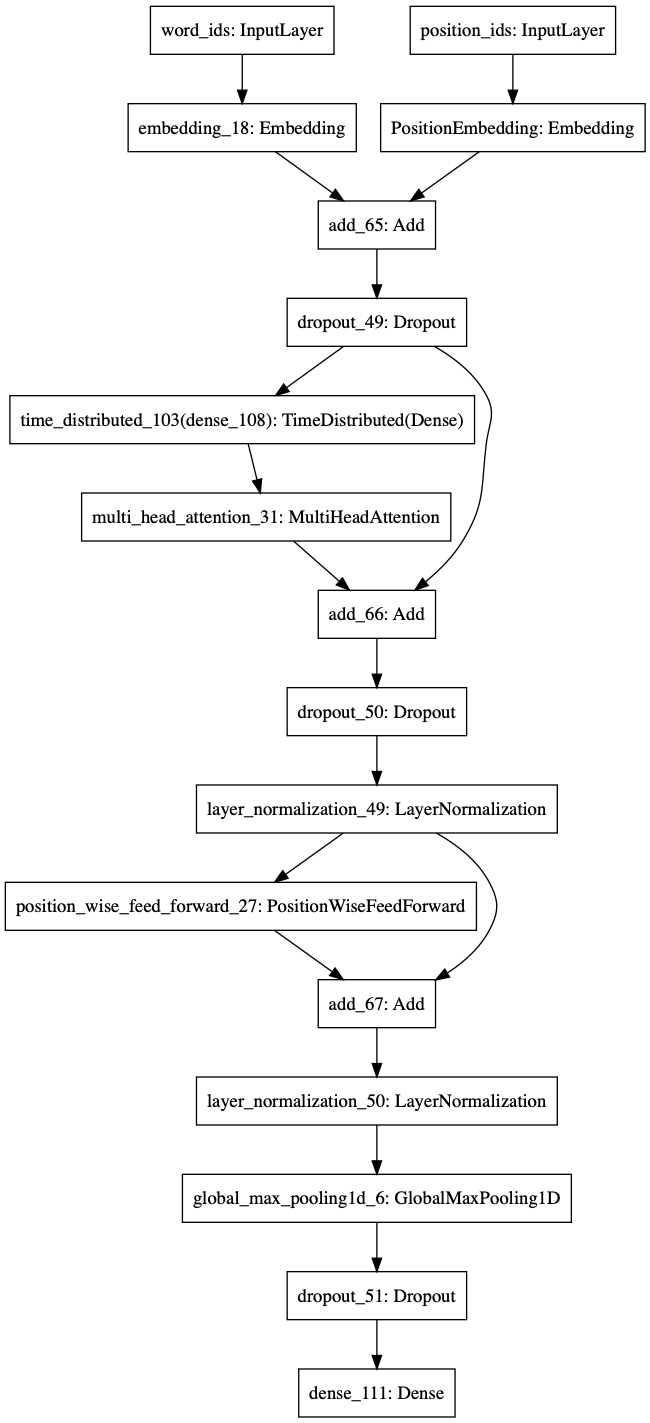

In [45]:
%matplotlib notebook

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image 
Image('model.png')